# <a id='toc1_'></a>[Example of usage of <b>sing_curr_conv</b> on the example.beancount from the beancount repository](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Example of usage of sing_curr_conv.py on the example.beancount from the beancount repository](#toc1_)    
  - [Purpose and scope](#toc1_1_)    
  - [Notebook preparation](#toc1_2_)    
    - [Importing needed modules and defining some helper functions](#toc1_2_1_)    
  - [Analysis](#toc1_3_)    
    - [Analysis using the original ledger.](#toc1_3_1_)    
      - [Net Worth](#toc1_3_1_1_)    
      - [Net Worth Change on the original ledger](#toc1_3_1_2_)    
        - [Houston, we have a problem! (unexplained Neth Worth)](#toc1_3_1_2_1_)    
    - [Analysis, using the equivalent ledger, converted to the single currency by the **sing_curr_conv**](#toc1_3_2_)    
      - [Net Wort Change on the converted ledger](#toc1_3_2_1_)    
        - [Bingo! No unexplained Neth Worth! (Guarantee 2)](#toc1_3_2_1_1_)    
    - [In depth analysis of the unrealized gains](#toc1_3_3_)    
      - [Which commodities caused the gain?](#toc1_3_3_1_)    
      - [Were they all tracked at cost?](#toc1_3_3_2_)    
      - [What are the accounts, which had unrealized gains](#toc1_3_3_3_)    
  - [Appendixes](#toc1_4_)    
    - [Appendex A. Verification of the Guarantee 1](#toc1_4_1_)    
    - [Appendex B. Verification of the Guarantee 3](#toc1_4_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Purpose and scope](#toc0_)
This document provides an example of how the **sing_curr_conv**  can be used to perform the **Net Worth Change** and **Unrealized Gains** analysis on the unmodified copy of the [example.beancount](https://github.com/beancount/beancount/blob/master/examples/example.beancount) file, supplied with  [beancount](https://github.com/beancount/beancount). 

In addition, for illustration purposes the verification of the [Guarantee 1, 2 and 3](sing_curr_conv.md) is provided.

Note, that Jupyter notebook is used for illustrative purposes and also to allow interactions for a reader. Similar analysis can be done using the **sing_curr_conv.py** from a command line or as a plugin (refer to the [sing_curr_conv.md](sing_curr_conv.md) for more details).



## <a id='toc1_2_'></a>[Notebook preparation](#toc0_)
This section are just some preparations of the Jupyter notebook

### <a id='toc1_2_1_'></a>[Importing needed modules and defining some helper functions](#toc0_)

In [1]:
from decimal import Decimal
import datetime
from io import StringIO

import pandas as pd
# importing matplotlib module
import matplotlib.pyplot as plt

from beancount.loader import load_file
from beancount.parser import printer
from evbeantools.sing_curr_conv import get_equiv_sing_curr_entries
from beanquery.query import run_query

from evbeantools.juptools import  add_total, beanquery2df

In [2]:
pd.options.display.float_format = "{:,.2f}".format

In [3]:

def get_net_worth(entries, options, currency : str | None, 
                  date: datetime.date, 
                  account_depth: int = 1000) -> pd.DataFrame:
    """
    Uses a beanquery engin to calculate a net worth, broken down by the Balance Sheet accounts
    
    If currency is specified, then it attempts to convert the result to a single currency.    
    Following the standard accounting practices, when converting to a single currency, 
    the exchange rate is taken at the date for which the net worth is calculated.
    
    Following the standard functionality of beanquery, if result cannot be converted to a single currency, then the 
    values in unconvertable currencies are returned as they are.
    
    Args:
        entries: list of entries
        options: dict with options
        currency: str, currency to convert to
        date: datetime.date, date for which to calculate the net worth
        account_depth: int, depth of the account to group by. E.g. if 2 is provided, then the account 
                       `Assets:BankA:Saving` will be truncated to the `Assets:BankA`.
        
    Returns:
        results of the query, presented as a pandas DataFrame

    """
    
    date_iso: str = date.isoformat()
    
    name_assets = options["name_assets"]
    name_liabilities = options["name_liabilities"]
    
    query = None
    
    if currency:
        query = f"""
        SELECT root(account, {account_depth}) as account, convert(SUM(position),'{currency}',{date_iso}) as amount
        where date <= {date_iso} AND account ~ '{name_assets}|{name_liabilities}'
        """
    else:
        query = f"""
        SELECT root(account, {account_depth}) as account, SUM(position) as amount
        where date <= {date_iso} AND account ~ '{name_assets}|{name_liabilities}'
        """

    res = beanquery2df(entries, options, query)
    
    return res


def get_statement_of_net_worth_change(entries, options, 
                                      currency: str | None, 
                                      start_date: datetime.date, 
                                      end_date: datetime.date, 
                                      account_depth:int = 1000) -> pd.DataFrame:
    
    """
    Uses a beanquery engin to calculate a statement of change in net worth over a period of time groupped by an account 
    and attempts to convert the result to a single currency. 

    Changes to net worth are defined as the ones, coming from postings to the Income, Expenses or Equity accounts over 
    the specified period. 
    
    Following the standard accounting practices, when/if converting to a single currency, 
    the exchange rate is taken at the date of each individual transaction.
    
    Following the standard functionality of beanquery, if result cannot be converted to a single currency, then the 
    values in unconvertable currencies are returned as is.    
    
    Args:
        entries: list of entries
        options: dict with options
        currency: str, currency to convert to
        start_date: datetime.date, start date of the period
        end_date: datetime.date, end date of the period
        account_depth: int, depth of the account to group by. E.g. if 2 is provided, then the account 
                       `Expenses:Misc:Shopping` will be truncated to `Expenses:Misc`
        
    Returns:
        results of the query, presented as a pandas DataFrame 
    """
    
    start_date_iso = start_date.isoformat()
    end_date_iso = end_date.isoformat()
    
    name_expenses = options["name_expenses"]
    name_income = options["name_income"]
    name_equity = options["name_equity"]
    
    if currency:
    # Converting with the date being the date of the transaction
        query = f"""
        SELECT root(account, {account_depth}) as account, SUM(convert(position, '{currency}', date)) as amount
        WHERE account ~ '{name_expenses}|{name_income}|{name_equity}' AND
        date >= {start_date_iso} AND
        date <= {end_date_iso} 
        """
    else:
        query = f"""
        SELECT root(account, {account_depth}) as account, SUM(position) as amount
        WHERE account ~ '{name_expenses}|{name_income}|{name_equity}' AND
        date >= {start_date_iso} AND
        date <= {end_date_iso} 
        """
    res = beanquery2df(entries, options, query)
    
    return res

## <a id='toc1_3_'></a>[Analysis](#toc0_)


### <a id='toc1_3_1_'></a>[Analysis using the original ledger.](#toc0_)

Let us load the ledger file and check for errors

In [4]:
beancount_file = "example.beancount"

Just checking the 1st 20 lines of the the ledger file

In [5]:
with open(beancount_file, "r") as f:
    beancount_file_content = f.read()

print("\n".join(beancount_file_content.splitlines()[:20]))

;; -*- mode: org; mode: beancount; -*-
;; Birth: 1980-05-12
;; Dates: 2013-01-01 - 2015-12-21
;; THIS FILE HAS BEEN AUTO-GENERATED.
* Options

option "title" "Example Beancount file"
option "operating_currency" "USD"



* Commodities


1792-01-01 commodity USD
  export: "CASH"
  name: "US Dollar"

1900-01-01 commodity VMMXX
  export: "MUTF:VMMXX (MONEY:USD)"


In [6]:
entries_orig, errors_orig, opts_orig = load_file(beancount_file)

# Making sure, that there are no errors in the file
printer.print_errors(errors_orig)

Let us determine the date of the first and the last date in ledger

In [7]:

last_ledger_date = beanquery2df(entries_orig, opts_orig, "select max(date)").iloc[0,0]
last_ledger_date

datetime.date(2015, 12, 20)

In [8]:
first_ledger_date = beanquery2df(entries_orig, opts_orig, "select min(date)").iloc[0,0]
first_ledger_date

datetime.date(2013, 1, 1)

#### <a id='toc1_3_1_1_'></a>[Net Worth](#toc0_)

Let us see the total Net Worth built over the entire period, expressed in the original currency / commodity.

In [9]:
net_worth_mult_curr = get_net_worth(entries_orig, opts_orig, None, last_ledger_date).fillna(0)
net_worth_mult_curr_with_total = add_total(net_worth_mult_curr,col_name_to_add_to="account")
net_worth_mult_curr_with_total

,account,amount (USD),amount (VHT),amount (VEA),amount (VBMPX),amount (VACHR),amount (RGAGX),amount (ITOT),amount (GLD)
0,Assets:US:BofA:Checking,"3,043.23",0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,Assets:US:Federal:PreTax401k,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,Assets:US:Vanguard:Cash,-0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,Assets:US:Hoogle:Vacation,0.00,0.00,0.00,0.00,-26.00,0.00,0.00,0.00
4,Liabilities:US:Chase:Slate,"-2,941.56",0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,Assets:US:Vanguard:VBMPX,0.00,0.00,0.00,415.51,0.00,0.00,0.00,0.00
6,Assets:US:Vanguard:RGAGX,0.00,0.00,0.00,0.00,0.00,281.67,0.00,0.00
7,Assets:US:ETrade:Cash,"5,525.09",0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,Assets:US:ETrade:VHT,0.00,185.00,0.00,0.00,0.00,0.00,0.00,0.00
9,Assets:US:ETrade:VEA,0.00,0.00,172.00,0.00,0.00,0.00,0.00,0.00


We can see, that the net worth is presented in 8 commodities.

Let us now try to convert this Net Worth to USD. 

In [10]:
net_worth_orig = get_net_worth(entries_orig, opts_orig, "USD", last_ledger_date).fillna(0)
# Adding a Total row
net_worth_orig_with_total = add_total(net_worth_orig, col_name_to_add_to="account")
net_worth_orig_with_total

,account,amount (USD),amount (VACHR)
0,Assets:US:BofA:Checking,"3,043.23",0.00
1,Assets:US:Federal:PreTax401k,0.00,0.00
2,Assets:US:Vanguard:Cash,-0.12,0.00
3,Assets:US:Hoogle:Vacation,0.00,-26.00
4,Liabilities:US:Chase:Slate,"-2,941.56",0.00
5,Assets:US:Vanguard:VBMPX,"35,609.55",0.00
6,Assets:US:Vanguard:RGAGX,"66,678.79",0.00
7,Assets:US:ETrade:Cash,"5,525.09",0.00
8,Assets:US:ETrade:VHT,"7,927.25",0.00
9,Assets:US:ETrade:VEA,"9,133.20",0.00


Observe, that the ledger contains sufficient information (enough **price** entries) to convert everything to USD, except VACHR (which are the vacation hours).

#### <a id='toc1_3_1_2_'></a>[Net Worth Change on the original ledger](#toc0_)

Let us now try to analyze, how this Net Worth was built. For this we will run the **get_statement_of_net_worth_change** query on the original ledger. For illustrative purposes let us limit the depth of the account by 2 levels

In [11]:
statement_of_net_worth_change_orig = get_statement_of_net_worth_change(entries_orig, opts_orig, "USD", first_ledger_date, last_ledger_date, 2).fillna(0)
# Adding a Total row
statement_of_net_worth_change_orig_with_total = add_total(statement_of_net_worth_change_orig, col_name_to_add_to="account")
statement_of_net_worth_change_orig_with_total

,account,amount (USD),amount (VACHR),amount (IRAUSD)
0,Equity:Opening-Balances,"-3,219.17",0.00,0.00
1,Income:US,"-389,531.04",-390.00,"-53,000.00"
2,Expenses:Health,"7,558.20",0.00,0.00
3,Expenses:Taxes,"156,065.65",0.00,"53,000.00"
4,Expenses:Financial,654.15,0.00,0.00
5,Expenses:Food,"19,611.20",0.00,0.00
6,Expenses:Home,"91,175.05",0.00,0.00
7,Expenses:Transport,"3,960.00",0.00,0.00
8,Expenses:Vacation,0.00,416.00,0.00
9,Total,"-113,725.96",26.00,0.00


##### <a id='toc1_3_1_2_1_'></a>[Houston, we have a problem! (unexplained Neth Worth)](#toc0_)
We can see, that whilst we can explain how the 26 VACH were built (390 earned and then 416 spent), we cannot explain how exactly the total Net Worth in USD was built. Specifically the following amount USD is unexplanable:

In [12]:
unexplained_diff_USD = net_worth_orig_with_total.iloc[-1]["amount (USD)"] + statement_of_net_worth_change_orig_with_total.iloc[-1]["amount (USD)"]
unexplained_diff_USD

22158.780000000042

At this moment a taxman, your partner, your curiosity or all them may start asking [difficult questions](https://www.youtube.com/watch?v=kJ7HiO27n1g), which you [may not be able to answer](https://youtu.be/8SUgR11v0lQ?si=h4F_2gC1SY0dNVkx). 

Let us see, whether we can provide them answers using the **sing_curr_conv**

### <a id='toc1_3_2_'></a>[Analysis, using the equivalent ledger, converted to the single currency by the **sing_curr_conv**](#toc0_)
Let us create an **entries_eqv**, which holds the entries, representing the original ledger, but converted to the single currency (USD in this case) and also containing the unrealized gains transactions.

In [13]:
entries_eqv, errors_eqv, opts_eqv = get_equiv_sing_curr_entries(entries_orig, opts_orig, "USD", self_testing_mode=True, tolerance=0.1)

#### <a id='toc1_3_2_1_'></a>[Net Wort Change on the converted ledger](#toc0_)

Let us perform the same Net Worth Change analysis on these entries    

In [14]:
statement_of_net_worth_change_eqv = get_statement_of_net_worth_change(entries_eqv, opts_eqv, "USD", first_ledger_date, last_ledger_date, 2).fillna(0)
# adding a Total row
statement_of_net_worth_change_eqv_with_total = add_total(statement_of_net_worth_change_eqv, col_name_to_add_to="account")
statement_of_net_worth_change_eqv_with_total

,account,amount (USD),amount (VACHR),amount (IRAUSD)
0,Equity:Opening-Balances,"-3,219.17",0.00,0.00
1,Income:US,"-389,531.04",-390.00,"-53,000.00"
2,Expenses:Health,"7,558.20",0.00,0.00
3,Expenses:Taxes,"156,065.65",0.00,"53,000.00"
4,Expenses:Financial,654.15,0.00,0.00
5,Expenses:Food,"19,611.20",0.00,0.00
6,Expenses:Home,"91,175.05",0.00,0.00
7,Income:Unrealized-Gains,"-22,158.83",0.00,0.00
8,Expenses:Transport,"3,960.00",0.00,0.00
9,Expenses:Vacation,0.00,416.00,0.00


##### <a id='toc1_3_2_1_1_'></a>[Bingo! No unexplained Neth Worth! (Guarantee 2)](#toc0_)

Let us calculate the unexplained difference on the equivalent / converted ledger.

In [15]:
unexplained_diff_USD_eqv = statement_of_net_worth_change_eqv_with_total.iloc[-1]["amount (USD)"] + net_worth_orig_with_total.iloc[-1]["amount (USD)"]
unexplained_diff_USD_eqv

-0.04999999995925464

Observe, that now the unexplained Net Worth is virtually 0!! (Which is a [Guarantee 2](sing_curr_conv.md)). Celebrate responsibly <b> &#128521; </b>

### <a id='toc1_3_3_'></a>[In depth analysis of the unrealized gains](#toc0_)
Let us look at the unrealized gains only

#### <a id='toc1_3_3_1_'></a>[Which commodities caused the gain?](#toc0_)
The **sing_curr_conv** creates a separate unrealized gain account, where the commodity, which causes unrealized gain is mentioned as a last part of the name. 

E.g.:

**Income:Unrealized-Gains:\<Target Currency\>:\<Commodity which causes gain\>** Therefore to be able to break down unrealized gains per commodity, we just need to see the full length of the unrealized gains accounts 

In [16]:
unrealyzed_gains_dive_in_q = f"""
    SELECT account, SUM(convert(position, 'USD', date)) as amount
    WHERE account ~ '^Income:Unrealized-Gains' AND
    date >= {first_ledger_date} AND
    date <= {last_ledger_date} 
    """
unrealyzed_gains_dive_in_df = beanquery2df(entries_eqv, opts_eqv, unrealyzed_gains_dive_in_q)

# sort by the column 'amount (USD)' descending
unrealyzed_gains_dive_in_df = unrealyzed_gains_dive_in_df.sort_values(by="amount (USD)")

# Adding a Total row
unrealyzed_gains_dive_in_df_with_total = add_total(unrealyzed_gains_dive_in_df, col_name_to_add_to="account")
unrealyzed_gains_dive_in_df_with_total

,account,amount (USD)
0,Income:Unrealized-Gains:USD-RGAGX,"-18,978.59"
1,Income:Unrealized-Gains:USD-VBMPX,"-3,809.67"
2,Income:Unrealized-Gains:USD-ITOT,-167.73
3,Income:Unrealized-Gains:USD-VHT,108.38
4,Income:Unrealized-Gains:USD-GLD,308.22
5,Income:Unrealized-Gains:USD-VEA,380.57
6,Total,"-22,158.82"


Let us plot the results

In [17]:
# Extracting the name of the commodity, which had unrealized gains from the account name
unrealyzed_gains_dive_in_df["commodity"] = unrealyzed_gains_dive_in_df["account"].str.extract(r'.*-(\w*)$')
unrealyzed_gains_dive_in_df_selected = unrealyzed_gains_dive_in_df[["commodity", "amount (USD)"]]
unrealyzed_gains_dive_in_df_selected

,commodity,amount (USD)
1,RGAGX,"-18,978.59"
0,VBMPX,"-3,809.67"
2,ITOT,-167.73
4,VHT,108.38
5,GLD,308.22
3,VEA,380.57


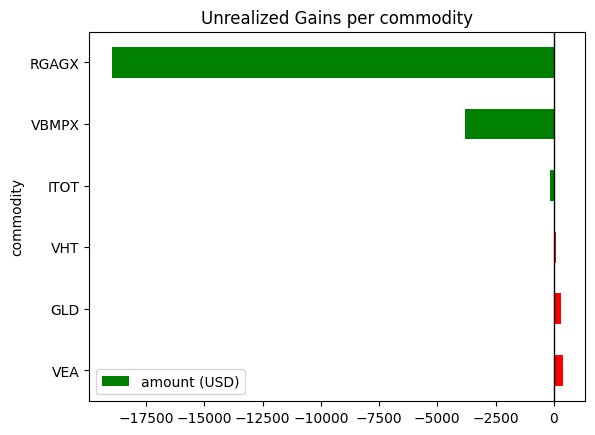

In [18]:
colors = ['green' if val < 0 else 'red' for val in unrealyzed_gains_dive_in_df_selected['amount (USD)']]
ax = unrealyzed_gains_dive_in_df_selected.plot(kind='barh', 
                                               x='commodity', 
                                               y='amount (USD)', 
                                               title="Unrealized Gains per commodity",
                                               color=colors)
ax.axvline(x=0, color='black', linewidth=1)
ax.invert_yaxis()

We can conclude, that most unrealized gains were caused by RGAGX and VBMPX

#### <a id='toc1_3_3_2_'></a>[Were they all tracked at cost?](#toc0_)
Let us add some information to see, whether the commudities, where we had unrealized gains on were tracked at cost or not. Normally positions, tracked at cost are the ones where one is expected to pay a capital gains tax eventually. To see this information we need to add the `meta['scc_at_cost']` to the query

In [19]:
unrealyzed_gains_dive_in_q = f"""
    SELECT account, meta['scc_at_cost'] as tracked_at_cost, SUM(convert(position, 'USD', date)) as amount
    WHERE account ~ '^Income:Unrealized-Gains' AND
    date >= {first_ledger_date} AND
    date <= {last_ledger_date} 
    """
unrealyzed_gains_dive_in_df = beanquery2df(entries_eqv, opts_eqv, unrealyzed_gains_dive_in_q).sort_values(by="amount (USD)")
unrealyzed_gains_dive_in_df = add_total(unrealyzed_gains_dive_in_df, col_name_to_add_to="account")
unrealyzed_gains_dive_in_df

,account,tracked_at_cost,amount (USD)
0,Income:Unrealized-Gains:USD-RGAGX,at_cost,"-18,978.59"
1,Income:Unrealized-Gains:USD-VBMPX,at_cost,"-3,809.67"
2,Income:Unrealized-Gains:USD-ITOT,at_cost,-167.73
3,Income:Unrealized-Gains:USD-VHT,at_cost,108.38
4,Income:Unrealized-Gains:USD-GLD,at_cost,308.22
5,Income:Unrealized-Gains:USD-VEA,at_cost,380.57
6,Total,NaN,"-22,158.82"


We can see, that all commodities, which cause unrealized gains were tracked at cost.

#### <a id='toc1_3_3_3_'></a>[What are the accounts, which had unrealized gains](#toc0_)
One may be interested which accounts had unrealized gains. To get this information let us udd the `meta['scc_bal_s_acc']` to our query.

In [20]:
unrealyzed_gains_dive_in_q = f"""
    SELECT account, meta['scc_bal_s_acc'] as scc_bal_s_acc,  SUM(convert(position, 'USD', date)) as amount
    WHERE account ~ '^Income:Unrealized-Gains' AND
    date >= {first_ledger_date} AND
    date <= {last_ledger_date} 
    """
unrealyzed_gains_dive_in_df = beanquery2df(entries_eqv, opts_eqv, unrealyzed_gains_dive_in_q).sort_values(by="amount (USD)")
unrealyzed_gains_dive_in_df = add_total(unrealyzed_gains_dive_in_df, col_name_to_add_to="account")
unrealyzed_gains_dive_in_df

,account,scc_bal_s_acc,amount (USD)
0,Income:Unrealized-Gains:USD-RGAGX,Assets:US:Vanguard:RGAGX,"-18,978.59"
1,Income:Unrealized-Gains:USD-VBMPX,Assets:US:Vanguard:VBMPX,"-3,809.67"
2,Income:Unrealized-Gains:USD-ITOT,Assets:US:ETrade:ITOT,-167.73
3,Income:Unrealized-Gains:USD-VHT,Assets:US:ETrade:VHT,108.38
4,Income:Unrealized-Gains:USD-GLD,Assets:US:ETrade:GLD,308.22
5,Income:Unrealized-Gains:USD-VEA,Assets:US:ETrade:VEA,380.57
6,Total,NaN,"-22,158.82"


We can see, that every commodity had it's own dedicated account

## <a id='toc1_4_'></a>[Appendixes](#toc0_)


### <a id='toc1_4_1_'></a>[Appendex A. Verification of the Guarantee 1](#toc0_)

For illustration perposes let us verify the [Guarantee 1](sing_curr_conv.md), namely that running the Net Worth query on the original and converted / equivalent ledger produces the same result.

In [21]:
# Let us calculate the net worth on the equivalent entries
net_worth_eqv = get_net_worth(entries_eqv, opts_eqv, "USD", last_ledger_date).fillna(0)
# Adding a Total row
net_worth_eqv_with_total = add_total(net_worth_eqv, col_name_to_add_to="account")
net_worth_eqv_with_total

,account,amount (USD),amount (VACHR)
0,Assets:US:BofA:Checking,"3,043.23",0.00
1,Assets:US:Federal:PreTax401k,0.00,0.00
2,Assets:US:Vanguard:Cash,-0.12,0.00
3,Assets:US:Hoogle:Vacation,0.00,-26.00
4,Liabilities:US:Chase:Slate,"-2,941.56",0.00
5,Assets:US:Vanguard:VBMPX,"35,609.55",0.00
6,Assets:US:Vanguard:RGAGX,"66,678.79",0.00
7,Assets:US:ETrade:Cash,"5,525.09",0.00
8,Assets:US:ETrade:VHT,"7,927.25",0.00
9,Assets:US:ETrade:VEA,"9,133.20",0.00


For easy comparison let us now merge original Net Worth report and the Net Worth report, run on the equivalent entries. Merging will be done on accounts. 

In [22]:
merged_net_worth = pd.merge(net_worth_orig_with_total, net_worth_eqv_with_total, 
                            how="outer", 
                            on="account", 
                            suffixes=('_orig', '_eqv')).infer_objects(copy=False).fillna(0)
merged_net_worth

,account,amount (USD)_orig,amount (VACHR)_orig,amount (USD)_eqv,amount (VACHR)_eqv
0,Assets:US:BofA:Checking,"3,043.23",0.00,"3,043.23",0.00
1,Assets:US:ETrade:Cash,"5,525.09",0.00,"5,525.09",0.00
2,Assets:US:ETrade:GLD,"6,812.07",0.00,"6,812.07",0.00
3,Assets:US:ETrade:ITOT,"4,097.24",0.00,"4,097.24",0.00
4,Assets:US:ETrade:VEA,"9,133.20",0.00,"9,133.20",0.00
5,Assets:US:ETrade:VHT,"7,927.25",0.00,"7,927.25",0.00
6,Assets:US:Federal:PreTax401k,0.00,0.00,0.00,0.00
7,Assets:US:Hoogle:Vacation,0.00,-26.00,0.00,-26.00
8,Assets:US:Vanguard:Cash,-0.12,0.00,-0.12,0.00
9,Assets:US:Vanguard:RGAGX,"66,678.79",0.00,"66,678.79",0.00


let us now add difference columns (**diff_**) to easily compare results

In [23]:
merged_net_worth_with_diff = merged_net_worth.copy()
merged_net_worth_with_diff["diff_USD"] = merged_net_worth_with_diff["amount (USD)_orig"] - merged_net_worth_with_diff["amount (USD)_eqv"]
merged_net_worth_with_diff["diff_VACHR"] = merged_net_worth_with_diff["amount (VACHR)_orig"] - merged_net_worth_with_diff["amount (VACHR)_eqv"]
merged_net_worth_with_diff

,account,amount (USD)_orig,amount (VACHR)_orig,amount (USD)_eqv,amount (VACHR)_eqv,diff_USD,diff_VACHR
0,Assets:US:BofA:Checking,"3,043.23",0.00,"3,043.23",0.00,0.00,0.00
1,Assets:US:ETrade:Cash,"5,525.09",0.00,"5,525.09",0.00,0.00,0.00
2,Assets:US:ETrade:GLD,"6,812.07",0.00,"6,812.07",0.00,0.00,0.00
3,Assets:US:ETrade:ITOT,"4,097.24",0.00,"4,097.24",0.00,0.00,0.00
4,Assets:US:ETrade:VEA,"9,133.20",0.00,"9,133.20",0.00,0.00,0.00
5,Assets:US:ETrade:VHT,"7,927.25",0.00,"7,927.25",0.00,0.00,0.00
6,Assets:US:Federal:PreTax401k,0.00,0.00,0.00,0.00,0.00,0.00
7,Assets:US:Hoogle:Vacation,0.00,-26.00,0.00,-26.00,0.00,0.00
8,Assets:US:Vanguard:Cash,-0.12,0.00,-0.12,0.00,0.00,0.00
9,Assets:US:Vanguard:RGAGX,"66,678.79",0.00,"66,678.79",0.00,0.00,0.00


We can see, that all rows in in the **diff_** columns are zero. Which confirms the [Guarantee 1](sing_curr_conv.md)

### <a id='toc1_4_2_'></a>[Appendex B. Verification of the Guarantee 3](#toc0_)

For demonstration purposes let us verify the [Guarantee 3](sing_curr_conv.md). Let us compare the Net Worth Change statement, done on the original entries and on the equivalent ones. For this we will merge 2 pandas dataframes by account name columns.

Columns, coming from the Net Worth Change query on the original entries, get the **_orig** suffix and the columns, coming from the entries, created by the **sing_curr_conv** get the **_eqv** suffix.

In [24]:
merged_statement_of_net_worth_change = pd.merge(statement_of_net_worth_change_orig_with_total, 
                                                  statement_of_net_worth_change_eqv_with_total, 
                                                  how="outer", 
                                                  on="account", 
                                                  suffixes=('_orig', '_eqv')).infer_objects(copy=False).fillna(0)
merged_statement_of_net_worth_change

,account,amount (USD)_orig,amount (VACHR)_orig,amount (IRAUSD)_orig,amount (USD)_eqv,amount (VACHR)_eqv,amount (IRAUSD)_eqv
0,Equity:Opening-Balances,"-3,219.17",0.00,0.00,"-3,219.17",0.00,0.00
1,Expenses:Financial,654.15,0.00,0.00,654.15,0.00,0.00
2,Expenses:Food,"19,611.20",0.00,0.00,"19,611.20",0.00,0.00
3,Expenses:Health,"7,558.20",0.00,0.00,"7,558.20",0.00,0.00
4,Expenses:Home,"91,175.05",0.00,0.00,"91,175.05",0.00,0.00
5,Expenses:Taxes,"156,065.65",0.00,"53,000.00","156,065.65",0.00,"53,000.00"
6,Expenses:Transport,"3,960.00",0.00,0.00,"3,960.00",0.00,0.00
7,Expenses:Vacation,0.00,416.00,0.00,0.00,416.00,0.00
8,Income:US,"-389,531.04",-390.00,"-53,000.00","-389,531.04",-390.00,"-53,000.00"
9,Income:Unrealized-Gains,0.00,0.00,0.00,"-22,158.83",0.00,0.00


For simplicity Let us look at the USD only

In [25]:
merged_statement_of_net_worth_change_reduced = merged_statement_of_net_worth_change[["account", "amount (USD)_orig", "amount (USD)_eqv"]].fillna(0)
merged_statement_of_net_worth_change_reduced

,account,amount (USD)_orig,amount (USD)_eqv
0,Equity:Opening-Balances,"-3,219.17","-3,219.17"
1,Expenses:Financial,654.15,654.15
2,Expenses:Food,"19,611.20","19,611.20"
3,Expenses:Health,"7,558.20","7,558.20"
4,Expenses:Home,"91,175.05","91,175.05"
5,Expenses:Taxes,"156,065.65","156,065.65"
6,Expenses:Transport,"3,960.00","3,960.00"
7,Expenses:Vacation,0.00,0.00
8,Income:US,"-389,531.04","-389,531.04"
9,Income:Unrealized-Gains,0.00,"-22,158.83"


Let us add the difference column

In [26]:
# Adding a difference column
merged_statement_of_net_worth_change_reduced_with_diff = merged_statement_of_net_worth_change_reduced.copy()
merged_statement_of_net_worth_change_reduced_with_diff["diff"] = merged_statement_of_net_worth_change_reduced["amount (USD)_orig"] - merged_statement_of_net_worth_change_reduced["amount (USD)_eqv"]
merged_statement_of_net_worth_change_reduced_with_diff

,account,amount (USD)_orig,amount (USD)_eqv,diff
0,Equity:Opening-Balances,"-3,219.17","-3,219.17",0.00
1,Expenses:Financial,654.15,654.15,0.00
2,Expenses:Food,"19,611.20","19,611.20",0.00
3,Expenses:Health,"7,558.20","7,558.20",0.00
4,Expenses:Home,"91,175.05","91,175.05",0.00
5,Expenses:Taxes,"156,065.65","156,065.65",0.00
6,Expenses:Transport,"3,960.00","3,960.00",0.00
7,Expenses:Vacation,0.00,0.00,0.00
8,Income:US,"-389,531.04","-389,531.04",0.00
9,Income:Unrealized-Gains,0.00,"-22,158.83","22,158.83"


Observe, that the **statement_of_net_worth_change** done on the original entries and on the equivalent ones is the same for all accounts, except the account  **Income:Unrealized-Gains**, present in the entries, created by the **sing_curr_conv**. With this we demonstrated the [Guarantee 3](sing_curr_conv.md) 